In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('ner_dataset.csv', low_memory=False)

In [3]:
data.head()

,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O


In [4]:
data.groupby("sentence_idx").head()

,sentence_idx,word,tag
0,1,Thousands,O
1,1,of,O
2,1,demonstrators,O
3,1,have,O
4,1,marched,O
...,...,...,...
1048557,47850,to,O
1048558,47850,deploy,O
1048572,47851,Last,O
1048573,47851,month,O


In [5]:
data['tag'].value_counts()

O                  888072
B-geo               37444
B-tim               20159
B-org               20134
I-per               17346
B-per               16975
I-org               16498
B-gpe               16368
I-geo                7396
I-tim                6291
B-art                 434
B-eve                 348
I-eve                 297
I-art                 280
I-gpe                 229
B-nat                 226
I-nat                  76
prev-prev-lemma         1
Name: tag, dtype: int64

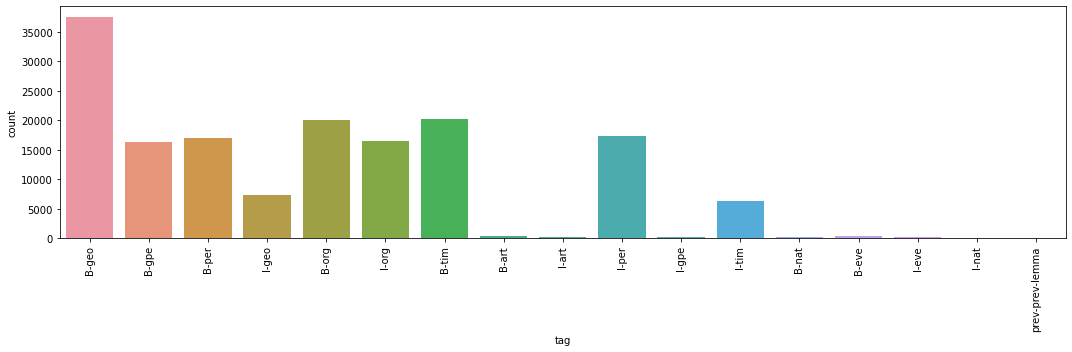

In [6]:
plt.figure(figsize=(15, 5))
ax = sns.countplot(x='tag', data=data.loc[data['tag'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [7]:
class SentenceGetter(object):
    
    def __init__(self, dataset):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [(w, t) for w,t in zip(s["word"].values.tolist(),
                                                        s["tag"].values.tolist())]
        self.grouped = self.dataset.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
          
getter = SentenceGetter(data)
sentences = getter.sentences

In [8]:
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O'), ('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [9]:
words = list(set(data["word"].values))
n_words = len(words)
n_words

30128

In [10]:
tags = []
i=0
for tag in set(data["tag"].values):
    if tag is nan or isinstance(tag, float):
        tags.append('unk')
    else:
        tags.append(tag)
n_tags = len(tags)
n_tags

19

In [11]:
from future.utils import iteritems

word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {v: k for k, v in iteritems(tag2idx)}

In [12]:
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

maxlen = max([len(s) for s in sentences])

Using TensorFlow backend.


In [13]:
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post",value=n_words - 1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["O"])
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [16]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense,SpatialDropout1D, TimeDistributed, Dropout, Bidirectional
import keras
import tensorflow as tf
def mymodel():
    word_embedding_size = 150
    input_word = Input(shape=(maxlen,))
    model = Embedding(input_dim=n_words,
                      output_dim=word_embedding_size,
                      input_length=maxlen)(input_word)
    model = SpatialDropout1D(0.1)(model)
    model = Bidirectional(LSTM(units=100,
                               return_sequences=True,
                               recurrent_dropout=0.1,
                               activation="tanh",
                               recurrent_activation="sigmoid"))(model)
    out = TimeDistributed(Dense(n_tags,activation='softmax'))(model)
    model = Model(input_word,out)

    model.compile(optimizer = 'adam',
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model
model = mymodel()
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 140)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 140, 150)          4519200   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 140, 150)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 140, 200)          200800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 140, 19)           3819      
Total params: 4,723,819
Trainable params: 4,723,819
Non-trainable params: 0
_________________________________________________________________


In [18]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1, verbose=0, mode='max',restore_best_weights= False)
callbacks = [early_stopping]

# Fit the best model
history = model.fit(X_train, 
                    np.array(y_train), 
                    batch_size=256, 
                    epochs=20, 
                    validation_split=0.1, 
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/20
99/99 [==============================] - 243s 2s/step - loss: 0.8550 - accuracy: 0.9185 - val_loss: 0.1461 - val_accuracy: 0.9673
Epoch 2/20
99/99 [==============================] - 267s 3s/step - loss: 0.1290 - accuracy: 0.9677 - val_loss: 0.0909 - val_accuracy: 0.9731
Epoch 3/20
99/99 [==============================] - 244s 2s/step - loss: 0.0825 - accuracy: 0.9747 - val_loss: 0.0708 - val_accuracy: 0.9786
Epoch 4/20
99/99 [==============================] - 251s 3s/step - loss: 0.0614 - accuracy: 0.9824 - val_loss: 0.0494 - val_accuracy: 0.9872
Epoch 5/20
99/99 [==============================] - 288s 3s/step - loss: 0.0397 - accuracy: 0.9897 - val_loss: 0.0384 - val_accuracy: 0.9899
Epoch 6/20
99/99 [==============================] - 268s 3s/step - loss: 0.0291 - accuracy: 0.9922 - val_loss: 0.0344 - val_accuracy: 0.9906
Epoch 7/20
99/99 [==============================] - 272s 3s/step - loss: 0.0240 - accuracy: 0.9934 - val_loss: 0.0332 - val_accuracy: 0.9910
Epoch 8/20
99

KeyboardInterrupt: 

In [ ]:
model.evaluate(X_test, np.array(y_test))

In [19]:
model.save('Model.h5')